<a href="https://colab.research.google.com/github/AdityaShashank/ArtifactNet/blob/main/ArtifactNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?id=1kPPz8eECrYgz3ZaDXNgf1a7hXh3160sS
From (redirected): https://drive.google.com/uc?id=1kPPz8eECrYgz3ZaDXNgf1a7hXh3160sS&confirm=t&uuid=20eb8ee7-0091-4050-8ef1-f075bc3d5924
To: /content/ArtiFact_240K.zip
100%|██████████| 2.90G/2.90G [00:40<00:00, 71.6MB/s]
<ipython-input-1-92e7c87aa39c>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sampled = train_df.groupby(['class', 'label'], group_keys=False).apply(lambda x: x.sample(n=min(len(x), 40000))).reset_index(drop=True)
<ipython-input-1-92e7c87aa39c>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version 

✅ After filtering: Train = 163998, Val = 6000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1 - Loss: 2044.1864 - Real/Fake Acc: 0.9020


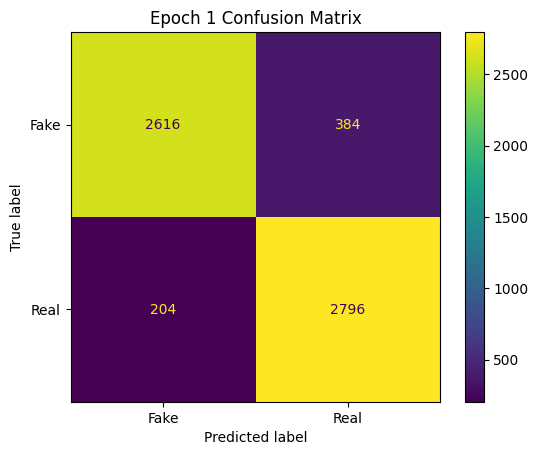

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3000
           1       0.88      0.93      0.90      3000

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000

Epoch 2 - Loss: 1809.0333 - Real/Fake Acc: 0.9138


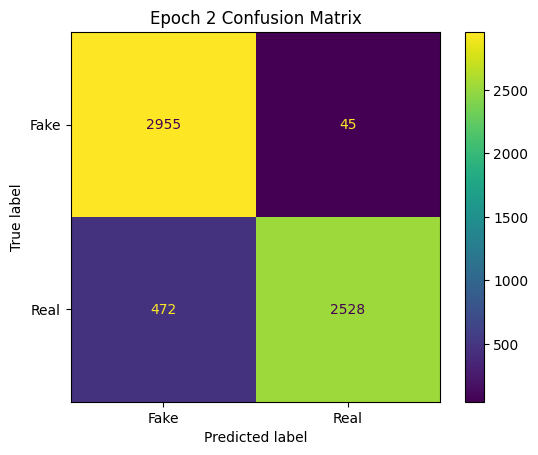

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      3000
           1       0.98      0.84      0.91      3000

    accuracy                           0.91      6000
   macro avg       0.92      0.91      0.91      6000
weighted avg       0.92      0.91      0.91      6000

Epoch 3 - Loss: 1733.3815 - Real/Fake Acc: 0.9490


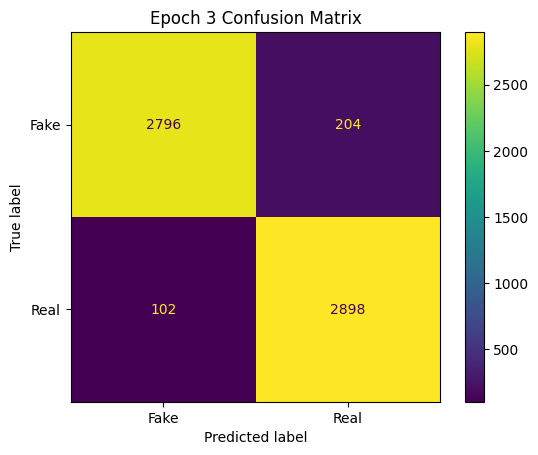

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3000
           1       0.93      0.97      0.95      3000

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Epoch 4 - Loss: 1687.3999 - Real/Fake Acc: 0.9540


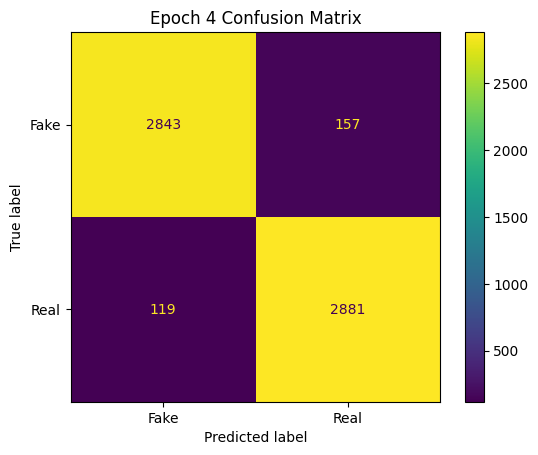

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3000
           1       0.95      0.96      0.95      3000

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Epoch 5 - Loss: 1658.0952 - Real/Fake Acc: 0.9603


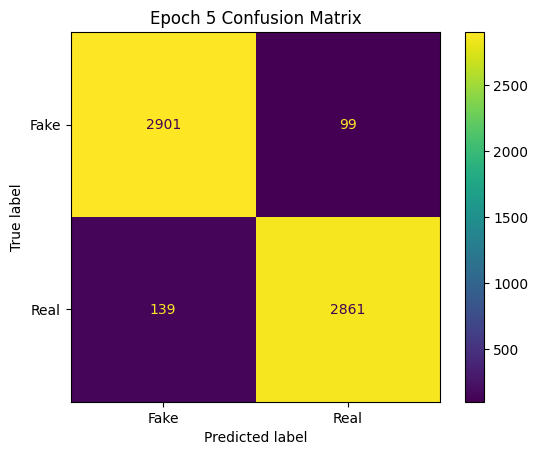

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3000
           1       0.97      0.95      0.96      3000

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

✅ submission.csv generated with 12002 entries


In [ ]:

!pip install -q timm gdown scikit-learn

# ✅ Download and extract the dataset
import gdown
!rm -rf /content/ArtiFact_240K
file_id = "1kPPz8eECrYgz3ZaDXNgf1a7hXh3160sS"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "ArtiFact_240K.zip", quiet=False)
!unzip -q ArtiFact_240K.zip -d /content/

# ✅ STEP 1: Load metadata and prepare data
import pandas as pd
import os

metadata = pd.read_csv("/content/ArtiFact_240K/metadata.csv")
metadata['image_path'] = metadata['image_path'].str.replace("ArtiFact_240K/", "", regex=False)

train_df = metadata[metadata['image_path'].str.contains("train")]
val_df = metadata[metadata['image_path'].str.contains("validation")]

# Use larger sample for better generalization
train_sampled = train_df.groupby(['class', 'label'], group_keys=False).apply(lambda x: x.sample(n=min(len(x), 40000))).reset_index(drop=True)
val_sampled = val_df.groupby(['class', 'label'], group_keys=False).apply(lambda x: x.sample(n=min(len(x), 1000))).reset_index(drop=True)

def filter_missing_files(df, root="/content/ArtiFact_240K"):
    df["full_path"] = df["image_path"].apply(lambda x: os.path.join(root, x))
    return df[df["full_path"].apply(os.path.exists)].drop(columns=["full_path"])

train_sampled = filter_missing_files(train_sampled)
val_sampled = filter_missing_files(val_sampled)
print(f"✅ After filtering: Train = {len(train_sampled)}, Val = {len(val_sampled)}")

# ✅ STEP 2: Dataset and transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class_map = {'human_faces': 0, 'animals': 1, 'vehicles': 2}
reverse_class_map = {v: k for k, v in class_map.items()}

def get_transforms():
    train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=15, translate=(0.05, 0.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train, val

train_transform, val_transform = get_transforms()

class DeepfakeDataset(Dataset):
    def __init__(self, df, root_dir, transform):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.root_dir, row['image_path'])
        image = Image.open(image_path).convert("RGB")
        label = torch.tensor(row['label'], dtype=torch.float32)
        class_label = torch.tensor(class_map[row['class']])
        return self.transform(image), label, class_label

    def __len__(self):
        return len(self.df)

train_loader = DataLoader(DeepfakeDataset(train_sampled, "/content/ArtiFact_240K", train_transform), batch_size=32, shuffle=True)
val_loader = DataLoader(DeepfakeDataset(val_sampled, "/content/ArtiFact_240K", val_transform), batch_size=32)

# ✅ STEP 3: Model
import torch.nn as nn
import timm

class DeepFakeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(0.3)
        self.real_head = nn.Linear(self.backbone.num_features, 1)
        self.class_head = nn.Linear(self.backbone.num_features, 3)

    def forward(self, x):
        features = self.dropout(self.backbone(x))
        return torch.sigmoid(self.real_head(features)).squeeze(1), self.class_head(features)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        eps = 1e-6
        pt = input * target + (1 - input) * (1 - target)
        loss = - (1 - pt + eps) ** self.gamma * torch.log(pt + eps)
        return loss.mean()

# ✅ STEP 4: Training
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_real = FocalLoss()
loss_class = nn.CrossEntropyLoss(label_smoothing=0.1)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, real_labels, class_labels in train_loader:
        imgs = imgs.to(device)
        real_labels = real_labels.to(device)
        class_labels = class_labels.to(device)

        pred_real, pred_class = model(imgs)
        loss = loss_real(pred_real, real_labels) + loss_class(pred_class, class_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, real_labels, _ in val_loader:
            imgs = imgs.to(device)
            real_labels = real_labels.to(device)
            pred_real, _ = model(imgs)
            preds.extend((pred_real > 0.5).int().cpu().tolist())
            targets.extend(real_labels.int().cpu().tolist())

    acc = accuracy_score(targets, preds)
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f} - Real/Fake Acc: {acc:.4f}")
    cm = confusion_matrix(targets, preds)
    ConfusionMatrixDisplay(cm, display_labels=["Fake", "Real"]).plot()
    plt.title(f"Epoch {epoch+1} Confusion Matrix")
    plt.show()
    print(classification_report(targets, preds))

# ✅ Save model weights
torch.save(model.state_dict(), "model.pth")

# ✅ STEP 5: Submission generation with formatted names using TTA
import glob
import csv

def tta_predict(model, img, transforms, device):
    model.eval()
    with torch.no_grad():
        outputs = []
        for t in transforms:
            tensor = t(img).unsqueeze(0).to(device)
            pred_real, pred_class = model(tensor)
            outputs.append((pred_real, pred_class))
        avg_real = torch.mean(torch.stack([p[0] for p in outputs]))
        avg_class = torch.mean(torch.stack([p[1] for p in outputs]), dim=0)
    return avg_real, avg_class

tta_transforms = [
    val_transform,
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), *val_transform.transforms]),
    transforms.Compose([transforms.RandomRotation(15), *val_transform.transforms])
]

model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

test_images = sorted(glob.glob("/content/ArtiFact_240K/test/*"))
submission_rows = []

from PIL import Image

for path in test_images:
    img = Image.open(path).convert("RGB")
    avg_real, avg_class = tta_predict(model, img, tta_transforms, device)
    label = int((avg_real.item() > 0.5))
    pred_class_idx = torch.argmax(avg_class).item()
    class_name = reverse_class_map[pred_class_idx]

    original_filename = os.path.basename(path)
    file_number = original_filename.split("_")[-1]
    file_ext = os.path.splitext(file_number)[1]
    file_id = os.path.splitext(file_number)[0]
    formatted_name = f"{class_name}_{file_id}{file_ext}"

    submission_rows.append([formatted_name, label, class_name])

with open("submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "label", "class"])
    writer.writerows(submission_rows)

print("✅ submission.csv generated with", len(submission_rows), "entries")


In [ ]:
torch.save(model.state_dict(), "/content/artifactnet_epoch5.pth")


In [ ]:
from google.colab import files
files.download("submission.csv")
files.download("/content/artifactnet_epoch5.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

metrics = pd.DataFrame({
    "epoch": [1, 2, 3, 4, 5],
    "accuracy": [0.9020, 0.9138, 0.9490, 0.9540, 0.9603],
    "loss": [2044.18, 1809.03, 1733.38, 1687.40, 1658.10]
})
metrics.to_csv("/content/metrics.csv", index=False)
files.download("/content/metrics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving putin-image.jpg to putin-image.jpg


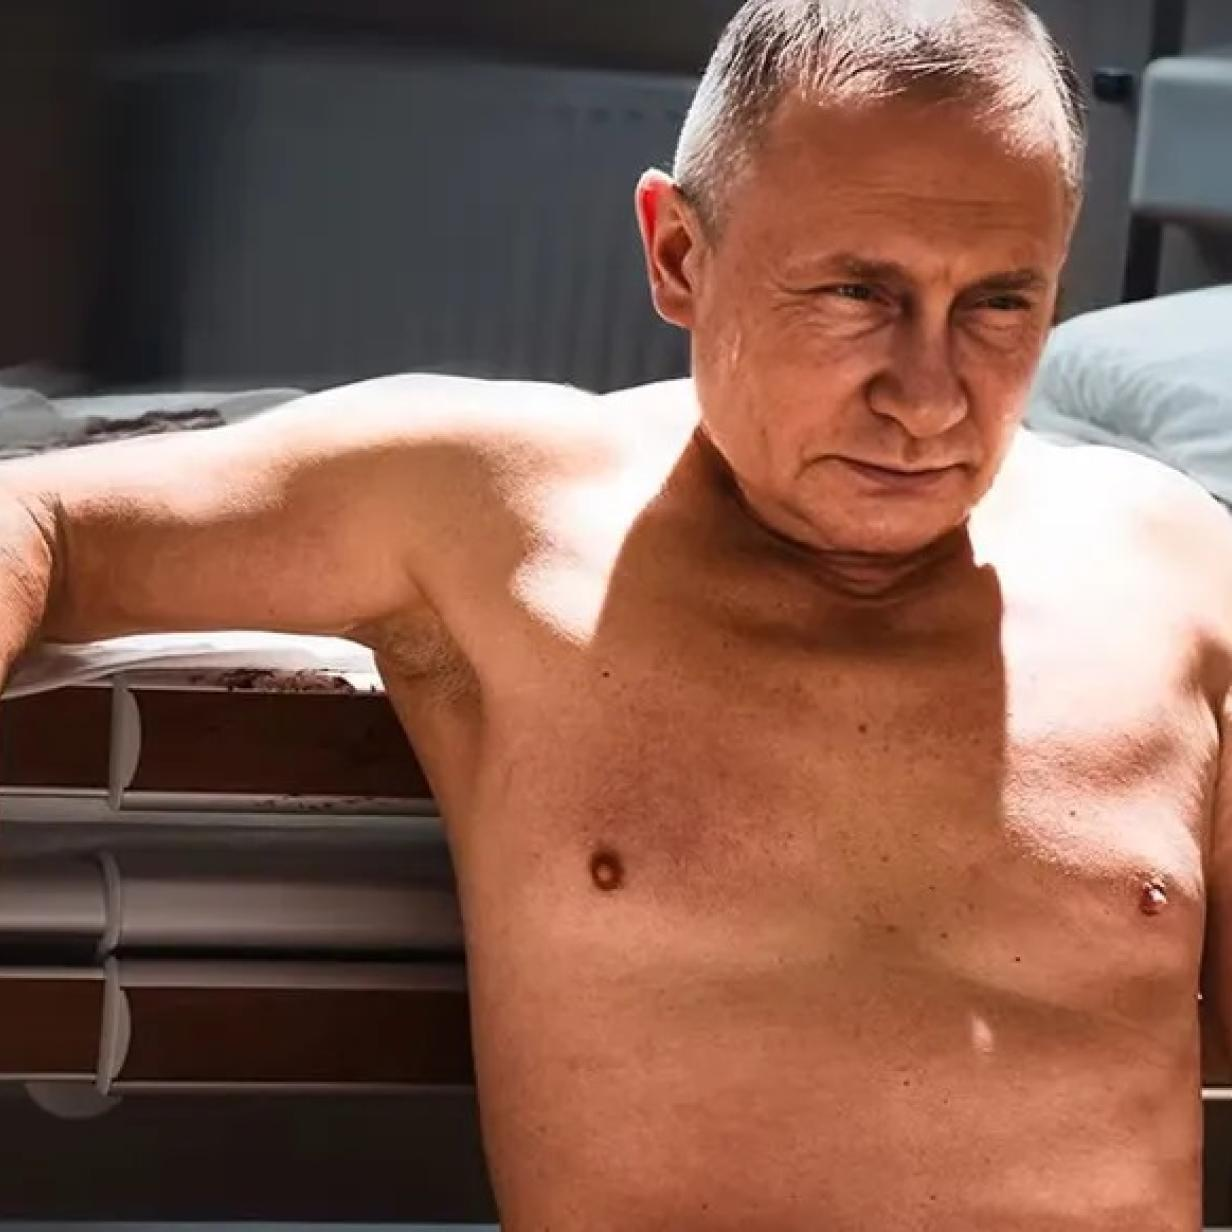

✅ Prediction: Fake | Class: vehicles


In [ ]:

from google.colab import files
from PIL import Image
from IPython.display import display

# Upload image
uploaded = files.upload()

# Make prediction for each uploaded image
for fname in uploaded:
    img = Image.open(fname).convert("RGB")
    display(img)

    input_tensor = val_transform(img).unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        pred_real, pred_class = model(input_tensor)
        label = "Real" if pred_real.item() > 0.5 else "Fake"
        class_name = reverse_class_map[torch.argmax(pred_class).item()]

    print(f"✅ Prediction: {label} | Class: {class_name}")


Saving testimage.jpg to testimage.jpg


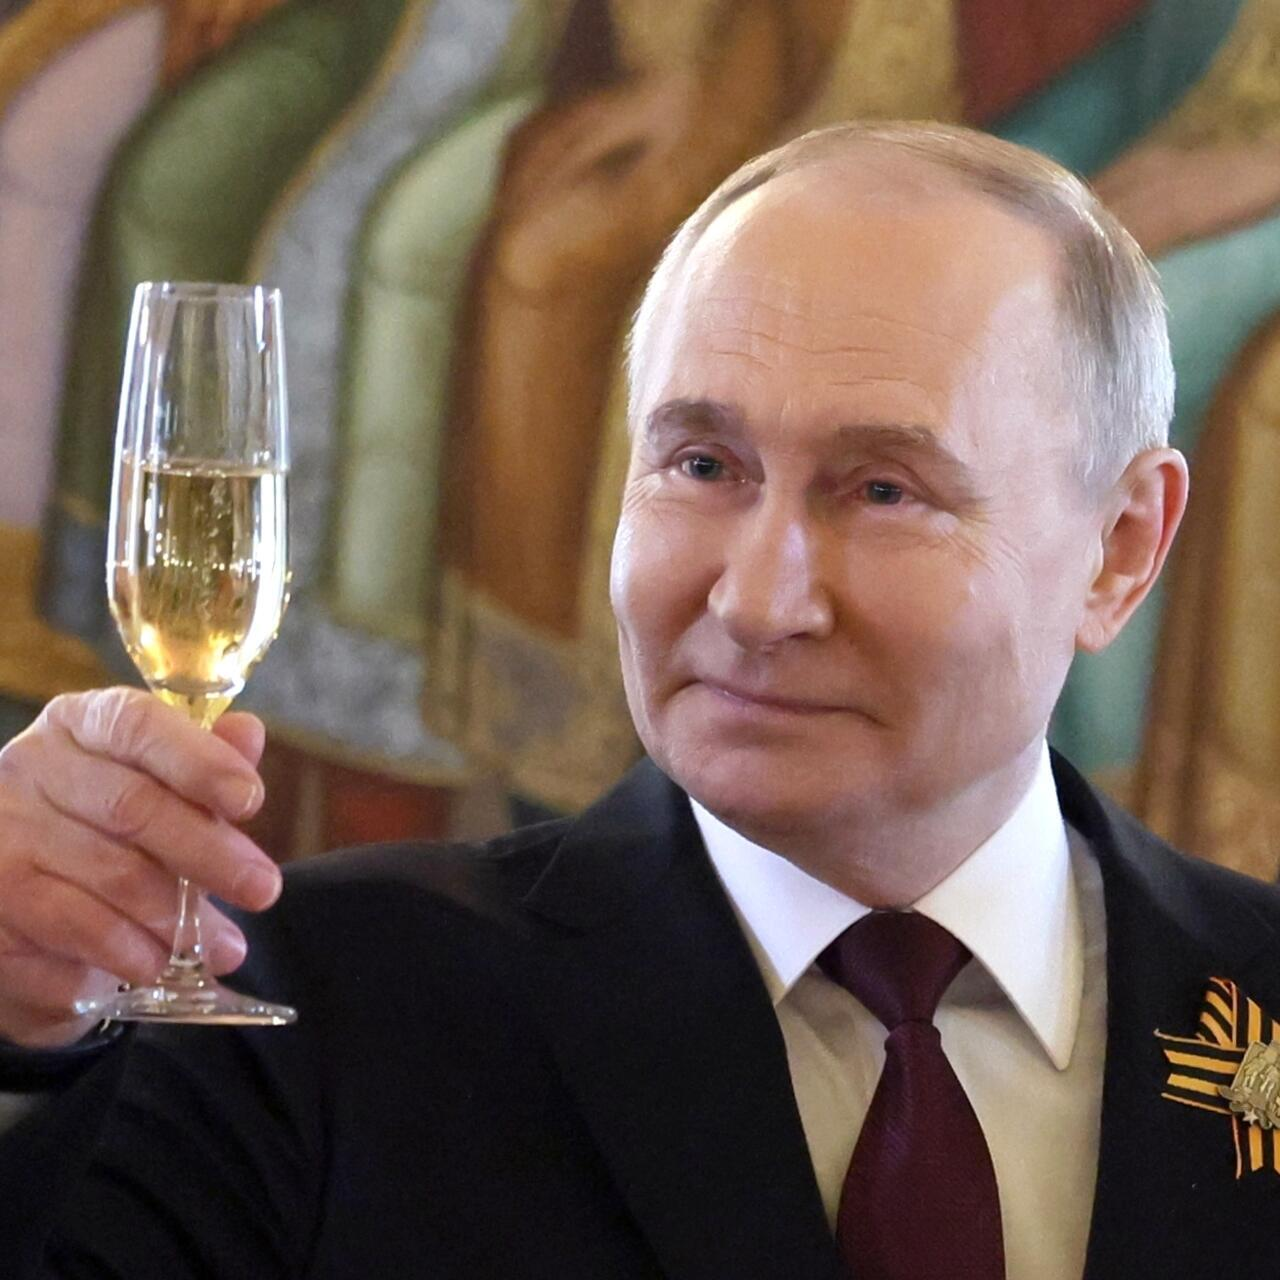

✅ Prediction: Real | Class: human_faces


In [ ]:

from google.colab import files
from PIL import Image
from IPython.display import display

# Upload image
uploaded = files.upload()

# Make prediction for each uploaded image
for fname in uploaded:
    img = Image.open(fname).convert("RGB")
    display(img)

    input_tensor = val_transform(img).unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        pred_real, pred_class = model(input_tensor)
        label = "Real" if pred_real.item() > 0.5 else "Fake"
        class_name = reverse_class_map[torch.argmax(pred_class).item()]

    print(f"✅ Prediction: {label} | Class: {class_name}")


In [ ]:
model.load_state_dict(torch.load("artifactnet_epoch5.pth", map_location=device))
model = model.to(device)


Saving putin-image.jpg to putin-image (1).jpg


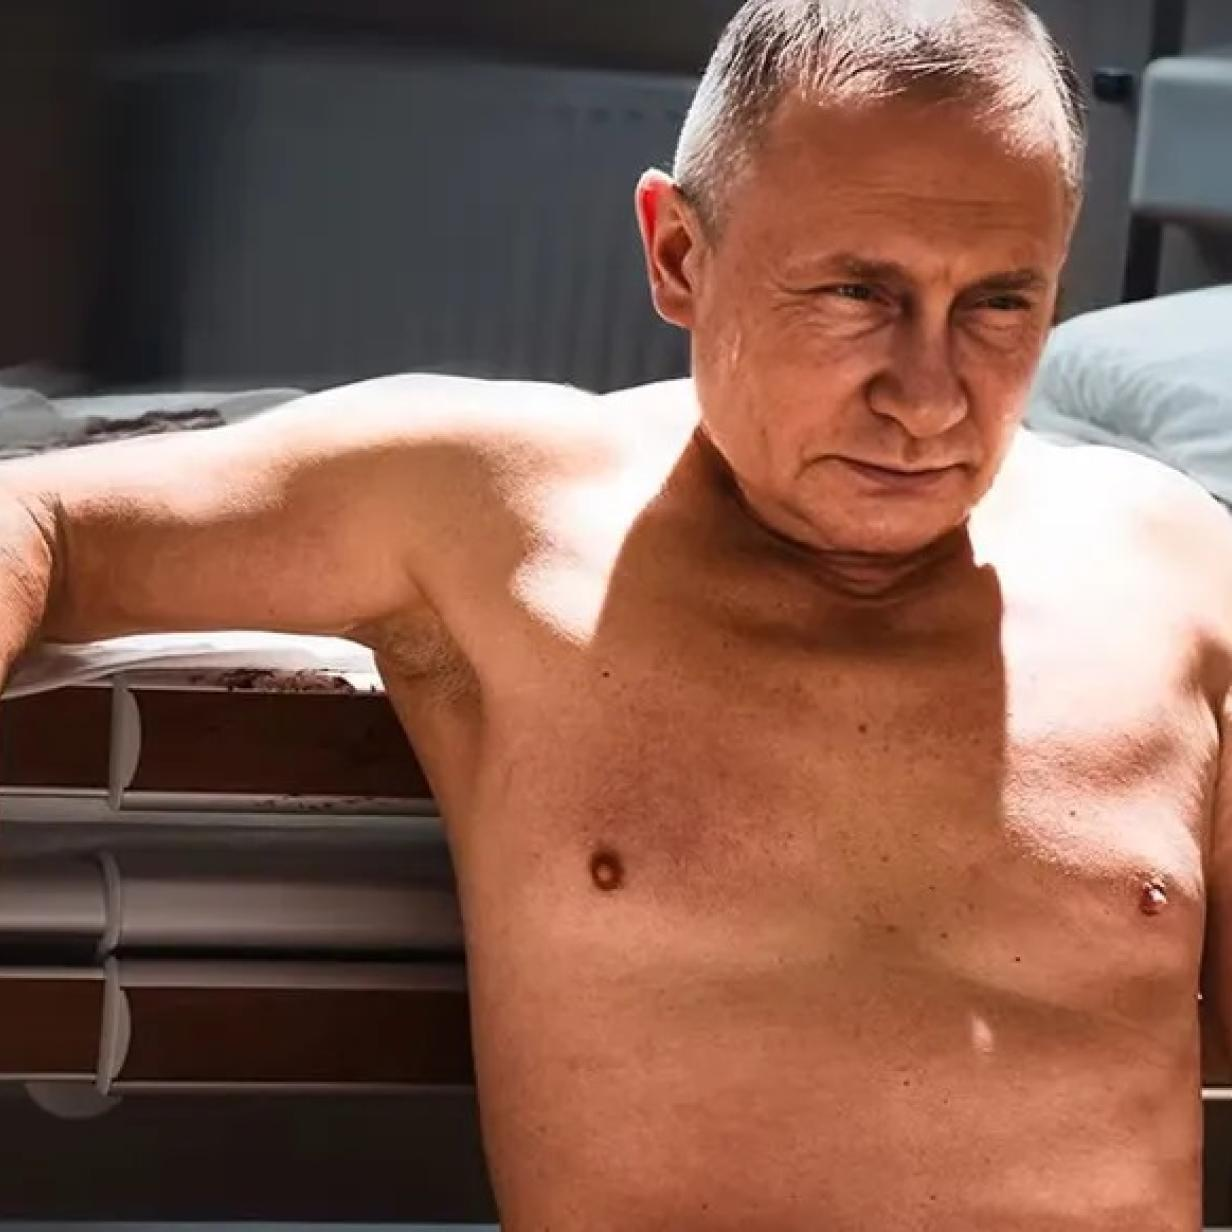

✅ Prediction: Fake | Class: vehicles


In [ ]:
from google.colab import files
from PIL import Image
from IPython.display import display
import torch

# Upload images
uploaded = files.upload()

# Make predictions
model.eval()
for fname in uploaded:
    img = Image.open(fname).convert("RGB")
    display(img)

    input_tensor = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_real, pred_class = model(input_tensor)
        label = "Real" if pred_real.item() > 0.5 else "Fake"
        class_name = reverse_class_map[torch.argmax(pred_class).item()]

    print(f"✅ Prediction: {label} | Class: {class_name}")


Saving tumus.png to tumus.png


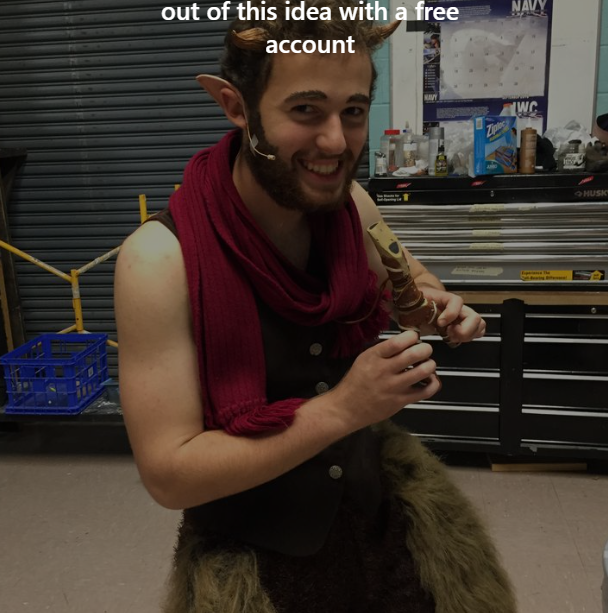

✅ Prediction: Fake | Class: vehicles


In [ ]:
from google.colab import files
from PIL import Image
from IPython.display import display
import torch

# Upload images
uploaded = files.upload()

# Make predictions
model.eval()
for fname in uploaded:
    img = Image.open(fname).convert("RGB")
    display(img)

    input_tensor = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_real, pred_class = model(input_tensor)
        label = "Real" if pred_real.item() > 0.5 else "Fake"
        class_name = reverse_class_map[torch.argmax(pred_class).item()]

    print(f"✅ Prediction: {label} | Class: {class_name}")


In [ ]:
tta_transforms = [
    val_transform,
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), *val_transform.transforms]),
    transforms.Compose([transforms.RandomRotation(15), *val_transform.transforms])
]

def tta_predict(model, img, tta_transforms):
    model.eval()
    with torch.no_grad():
        real_preds, class_preds = [], []
        for t in tta_transforms:
            input_tensor = t(img).unsqueeze(0).to(device)
            pred_real, pred_class = model(input_tensor)
            real_preds.append(pred_real.item())
            class_preds.append(pred_class.squeeze(0))
        avg_real = sum(real_preds) / len(real_preds)
        avg_class = torch.stack(class_preds).mean(0)
        class_idx = torch.argmax(avg_class).item()
    return avg_real, class_idx


In [ ]:
if 0.45 < avg_real < 0.55:
    label = "Uncertain"
else:
    label = "Real" if avg_real > 0.5 else "Fake"


In [ ]:
print(f"✅ Prediction: {label} ({avg_real:.2f}) | Class: {class_name}")


✅ Prediction: Fake (0.01) | Class: vehicles


Saving putin-image.jpg to putin-image (3).jpg


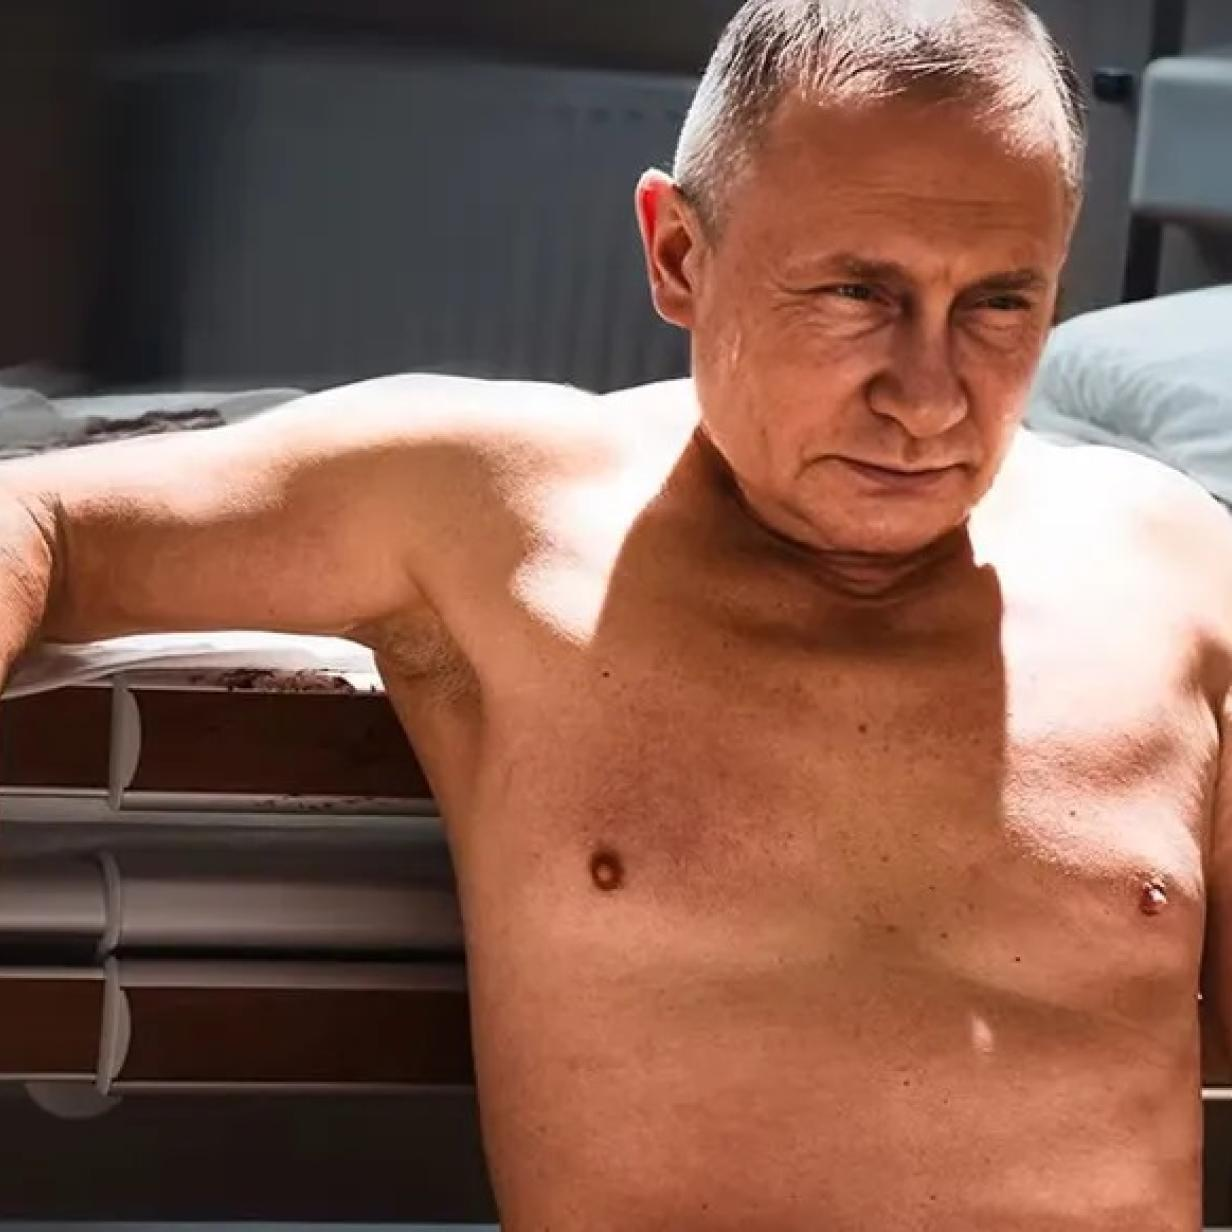

✅ Prediction: Fake | Class: vehicles


In [ ]:
from google.colab import files
from PIL import Image
from IPython.display import display

uploaded = files.upload()

for fname in uploaded:
    img = Image.open(fname).convert("RGB")
    display(img)

    avg_real, class_idx = tta_predict(model, img, tta_transforms)
    label = "Real" if avg_real > 0.5 else "Fake"
    class_name = reverse_class_map[class_idx]

    print(f"✅ Prediction: {label} | Class: {class_name}")


Saving tumus.png to tumus (1).png


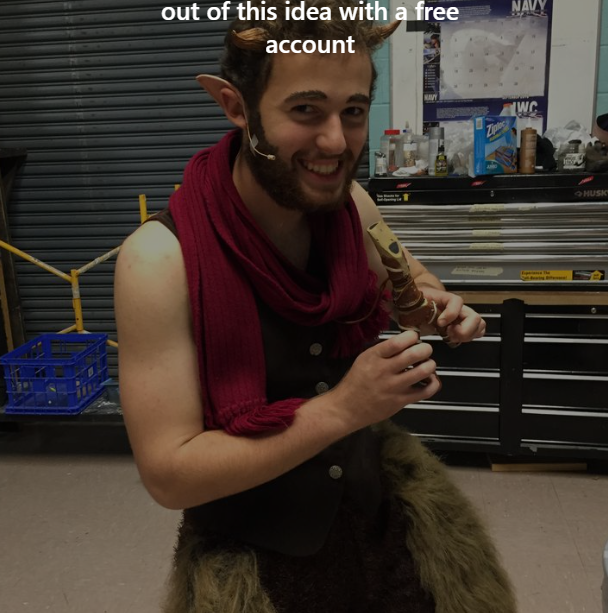

✅ Prediction: Fake | Class: vehicles


In [ ]:
from google.colab import files
from PIL import Image
from IPython.display import display

uploaded = files.upload()

for fname in uploaded:
    img = Image.open(fname).convert("RGB")
    display(img)

    avg_real, class_idx = tta_predict(model, img, tta_transforms)
    label = "Real" if avg_real > 0.5 else "Fake"
    class_name = reverse_class_map[class_idx]

    print(f"✅ Prediction: {label} | Class: {class_name}")
